Повний процесс навчання моделі на основі технології BERT. Починаючи зі збору сирих даних, їх нормалізацією, аналізу, закінчуючи готовою модделю, здатною розпізнавати визначені ознаки.

In [1]:
# Загальні імпорти
import os
import pandas as pd

Скрапер заголовків відео YouTube. Для роботи необхідний встановлений браузер Chrome.

Вхідні дані:
- url: Посилання на YouTube канал, вкладка "Відео"
- max_scrolls: Кількість скролів, яку зробить скрапер, збираючи заголовки. Один скрол рівний 30 заголовкам. Відлік скролів починається з 0

Вихідні дані:
- .csv файл із збереженими заголовками у стовпчику "titles"

In [4]:
from utils.scraper_utils import get_driver, scrape_titles, save_to_csv

# Параметри
url = "https://www.youtube.com/@SuspilneNews/videos"
max_scrolls = 20

# 1) Піднімаємо WebDriver
driver = get_driver(headless=False)   # headless=True, якщо не хочете бачити браузер

# 2) Збираємо заголовки
channelid, titles = scrape_titles(driver, url, max_scrolls=max_scrolls)

# 3) Закриваємо драйвер
driver.quit()

# 4) Зберігаємо результат
csv_path = save_to_csv(channelid, titles)
print(f"✅ Збережено {len(titles)} заголовків у {csv_path}")


✅ Збережено 628 заголовків у data/raw/SuspilneNews.csv


Наступним кроком є початкова обробка сирих даних:

1) Видаляємо всі заголовки, у яких кількість кирилиці <= 40% всіх символів. Це робиться для того, щоб виключити не україномовні заголовки;
2) Всі вхідні дані об'єднуються у єдиний корпус;
3) У єдиному корпусі створюються стовпчики "source" та "is_clickbait", значення яких прописується вручну у параметрі files_and_flags.

Вхідні дані:
- files_and_flags: словник з назвами вхідних файлів. Назва вхідного файлу задає значення стовпчику "source" результуючого корпусу.  Кожному вхідному файлу відповідає значення 0 або 1 (не-клікбейт/клікбейт), це значення заноситься у стовпчик "is_clickbait" результуючого корпусу
- base_dir: шлях до директорії з вхідними файлами

Вихідні дані:
- dataset.csv: єдиний корпус сирих україномовних даних, який містить стопчики "titles", "source", "is_clickbait"

In [5]:
from utils.text_utils import contains_cyrillic
from utils.dataframe_utils import load_csv, save_csv

# Параметри
files_and_flags = {
    '24Channel.csv':      1,
    'FaktyICTV.csv':      1,
    'RadioNV.csv':        0,
    'RadioSvoboda.csv':   0,
    'SuspilneNews.csv':   0,
    'UkraineTodayTV.csv': 1,
    'ViknaSTB.csv':       1,
}

base_dir = 'data/'

collected = []
for fname, flag in files_and_flags.items():
    in_path = os.path.join(base_dir, fname)
    df = load_csv(in_path)

    df = df[df['title'].apply(contains_cyrillic)].copy()

    source_name = os.path.splitext(fname)[0]
    df.insert(1, 'is_clickbait', flag)
    df.insert(2, 'source', source_name)

    collected.append(df)

df_merged = pd.concat(collected, ignore_index=True)
merged_out = os.path.join(base_dir, 'dataset.csv')
save_csv(df_merged, merged_out)
print(f"Створений єдиний корпус: dataset.csv ({len(df_merged)-1} заголовків)")

Створений єдиний корпус: dataset.csv (30000 заголовків)


Відразу можемо помітити деякі ознаки клікбейту. Наприклад, порівняємо відсоток великих літер у не-клікбейтних та клікбейтних джерелах.

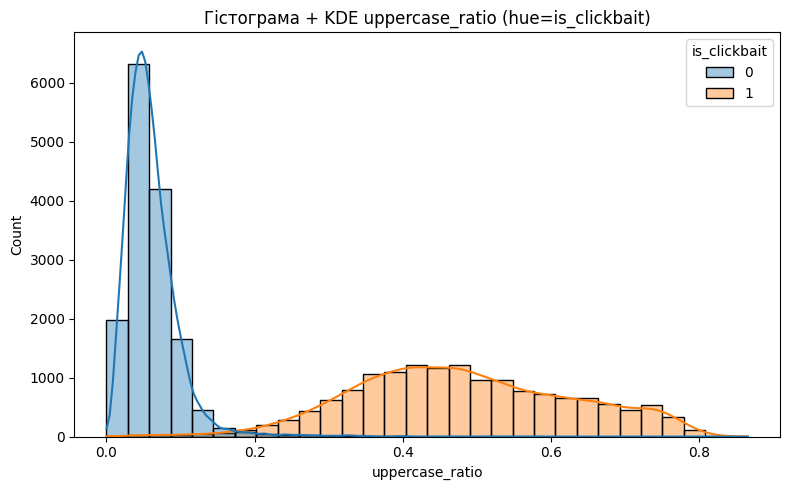

In [6]:
from utils.visual_utils import  plot_histogram
ur = df_merged['title'].astype(str).str.count(r'[A-ZА-ЯЁ]') / df_merged['title'].str.len().replace(0,1)
temp_df = pd.DataFrame({'uppercase_ratio': ur, 'is_clickbait': df_merged['is_clickbait']})
plot_histogram(
    temp_df,
    column='uppercase_ratio',
    bins=30,
    hue='is_clickbait'
)

Наступним кроком є нормалізація даних у корпусі:

In [7]:
from utils.dataframe_utils import clean_dataframe

df_clean = clean_dataframe(df_merged)
clean_out = os.path.join(base_dir, 'dataset_cleaned.csv')
save_csv(df_clean, clean_out)
print(f"Створений нормалізований корпус: dataset_cleaned.csv ({len(df_clean)-1} заголовків)")

Створений нормалізований корпус: dataset_cleaned.csv (30000 заголовків)


Наступним кроком є видалення найбільш популярних словосполучень, які є загальними фразами окремих джерел, які не мають відношення до конкретної новини. Наприклад, у джерела ICTV велика кількість заголовків містять словосполучення "новини факти ictv". Це має негативний вплив на навчання моделі: вона починає звертати увагу передусім на ці загальні словосполучення, а не на об'єктивний контекст окремої новини. Цей крок потребує ручної обробки.

In [8]:
from utils.dataframe_utils import get_top_ngrams

# Параметри
top_n = 10
ngram_range=(5, 5)

top_ngrams = get_top_ngrams(
    df_clean['title'],
    ngram_range=ngram_range,
    top_n=top_n
)

for ngram, count in top_ngrams:
    print(f"{ngram!r}: {count}")


'україни новини факти ictv за': 14
'що це означає для україни': 14
'рф новини факти ictv за': 13
'сша новини факти ictv за': 12
'заява трампа новини факти ictv': 11
'деталі новини факти ictv за': 11
'трампа новини факти ictv за': 11
'такого ви ще не бачили': 10
'на курщині новини факти ictv': 10
'росії новини факти ictv за': 10


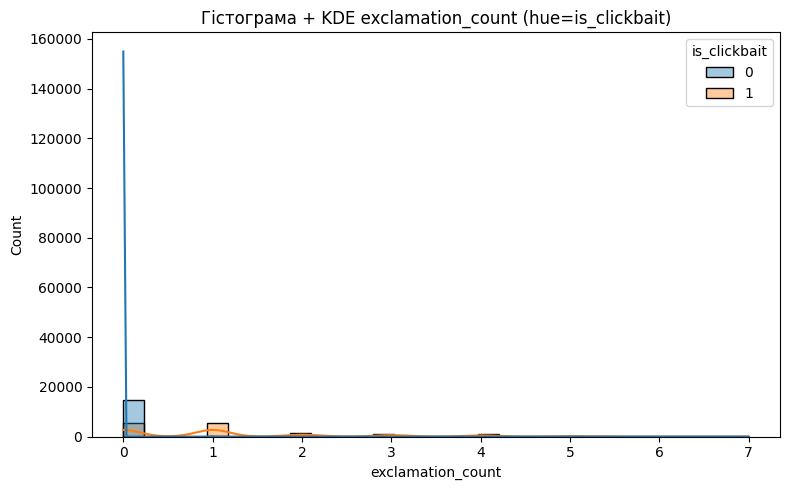

In [9]:
# Plot exclamation mark distribution
ec = df_clean['title'].astype(str).str.count('!')
temp_df = pd.DataFrame({'exclamation_count': ec, 'is_clickbait': df_clean['is_clickbait']})
plot_histogram(
    temp_df,
    column='exclamation_count',
    bins=30,
    hue='is_clickbait'
)

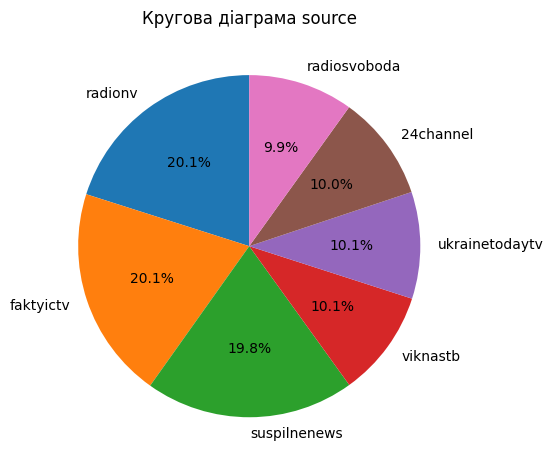

In [14]:
# Plot source distribution
from utils.visual_utils import  plot_pie
plot_pie(df_clean, 'source')


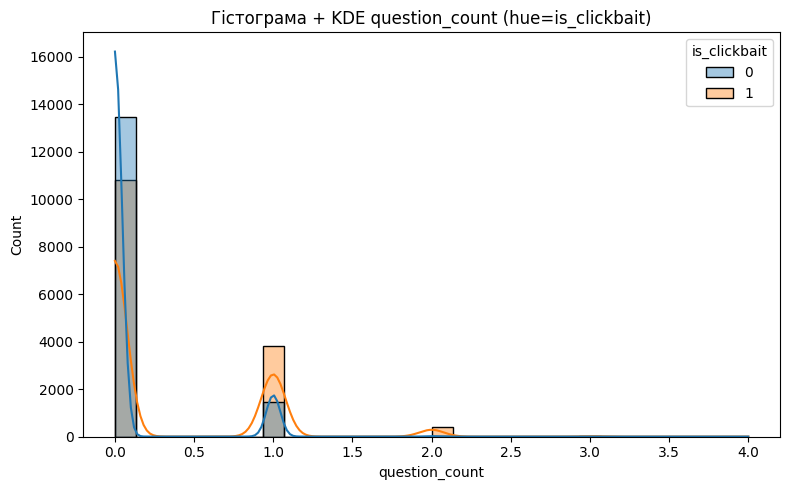

In [10]:
# Plot question mark distribution
qc = df_clean['title'].astype(str).str.count(r'\?')
temp_df = pd.DataFrame({'question_count': qc, 'is_clickbait': df_clean['is_clickbait']})
plot_histogram(
    temp_df,
    column='question_count',
    bins=30,
    hue='is_clickbait'
)

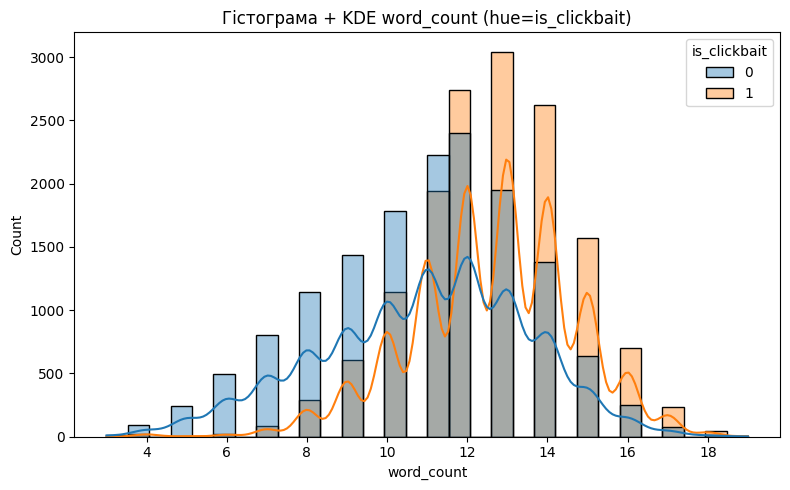

In [11]:
# Plot word count distribution
wc = df_clean['title'].astype(str).str.split().str.len()
temp_df = pd.DataFrame({
    'word_count': wc,
    'is_clickbait': df_clean['is_clickbait']
})
plot_histogram(
    temp_df,
    column='word_count',
    bins=30,
    hue='is_clickbait'
)


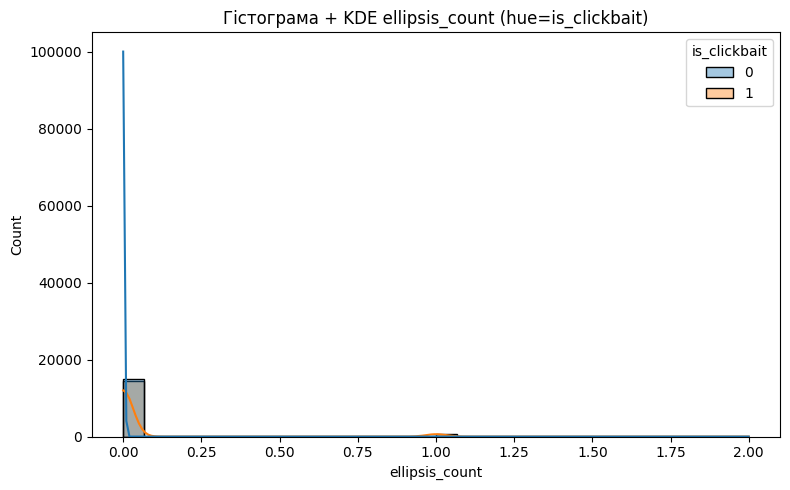

In [12]:
# Plot ellipsis distribution
elc = df_clean['title'].astype(str).str.count(r'\.\.\.')
temp_df = pd.DataFrame({'ellipsis_count': elc, 'is_clickbait': df_clean['is_clickbait']})
plot_histogram(
    temp_df,
    column='ellipsis_count',
    bins=30,
    hue='is_clickbait'
)

In [4]:
from utils.model_utils import train_and_save

# Параметри користувача
input_path = "data/dataset_cleaned.csv"
text_column = "title"
label_column = "is_clickbait"
encoders = ["xlm-roberta-large", "Goader/liberta-large-v2"]
classifiers = ["logreg", "linear_svc", "rf"]
batch_size = 32
cv_folds = 5
save_dir = "models/"

# Завантаження даних
df = pd.read_csv(input_path)

# Запуск тренування
train_and_save(
    df,
    text_column=text_column,
    label_column=label_column,
    encoders=encoders,
    classifiers=classifiers,
    batch_size=batch_size,
    cv_folds=cv_folds,
    save_dir=save_dir
)


Процесс (xlm-roberta-large): 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


→ Навчання моделі з енкодером xlm-roberta-large...
  Епоха 1/5: validation loss = 0.6487
  Епоха 2/5: validation loss = 0.6380
  Епоха 3/5: validation loss = 0.6273
  Епоха 4/5: validation loss = 0.6170
  Епоха 5/5: validation loss = 0.6070
→ Збережено модель до models/xlm-roberta-large_ptclassifier.pt


Процесс (Goader/liberta-large-v2): 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

→ Навчання моделі з енкодером Goader/liberta-large-v2...
  Епоха 1/5: validation loss = 0.6868
  Епоха 2/5: validation loss = 0.6709
  Епоха 3/5: validation loss = 0.6569
  Епоха 4/5: validation loss = 0.6437
  Епоха 5/5: validation loss = 0.6317
→ Збережено модель до models/Goader_liberta-large-v2_ptclassifier.pt
